# Submodular Optimization

This notebook performs sensor selection based on submodular optimization of 4 different criteria. The notebook works between Python and MATLAB, with data loading, processing, and analsis handled directely in the notebook and calls to `sbatch` calls to matlab scripts that perform the submodular optimization.

## Load and Preprocess the Data

In [1]:
# Imports
import pandas as pd
import numpy as np
from copy import deepcopy
import os
import sys
from importlib import reload
from scipy.stats import zscore
import scipy.io
from scipy.interpolate import make_interp_spline, BSpline
from scipy.signal import savgol_filter as savgol 
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import leidenalg
import umap
import time
import gget
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
import scipy
import textwrap
from scipy import sparse

from pydmd import DMD

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# local imports
sys.path.append("../python/")

import nb_util as nb
import utils as ut
reload(ut)

import hasnain_DMD
reload(hasnain_DMD)

def getC(n, idxs):
    C = np.zeros((len(idxs), n))
    for i in range(len(idxs)):
        C[i, int(idxs[i])] = 1
    return C

In [2]:
# Load data (taken exactly from Cooper)
data_path = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/RNA_pipeline_ouputs/countMatrix/counts.raw.txt"
gene_path = f"/nfs/turbo/umms-indikar/shared/projects/cell_cycle/data/RNA_pipeline_ouputs/references/geneTable.csv"

""" Load the raw expression """
df = pd.read_csv(data_path, index_col=0)

# remove MT and ribosomal genes
all_genes = df.index.to_list()
mt_genes = [x for x in all_genes if x.startswith('MT-')]
rp_genes = [x for x in all_genes if x.startswith('RP')]

print(f"{df.shape=}")
df = df.drop(mt_genes) # drop MT genes
df = df.drop(rp_genes) # drop ribosomal genes
print(f"{df.shape=}")

# rewrite the list without MT genes
gene_names = df.index.to_list()

print(f"{len(all_genes)=} {len(mt_genes)=} {len(gene_names)=}")

""" Load gene lengths """
gf = nb.getGeneLengths(gene_path, gene_names)
print(f"{gf.shape=}")

df.head()

df.shape=(19393, 18)
df.shape=(19235, 18)
len(all_genes)=19393 len(mt_genes)=13 len(gene_names)=19235


/home/jpic/DMD_gene/notebooks/nb_util.py:113: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  gf = pd.read_csv(gene_table_path)


gf.shape=(19235, 2)


,S1a,S1b,S2a,S2b,S3a,S3b,S4a,S4b,S5a,S5b,S6a,S6b,S7a,S7b,S8a,S8b,S9a,S9b
geneName,,,,,,,,,,,,,,,,,,
A1BG,12,5,5,9,2,6,7,3,6,5,5,5,4,3,4,5,5,3
A1CF,0,0,0,0,0,0,0,0,0,0,0,1,2,0,2,0,0,0
A2M,0,0,0,2,0,0,0,0,0,0,1,0,1,0,0,0,0,2
A2ML1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
A3GALT2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [52]:
target = 1e6
threshold = 7
rank = 7
tpm = nb.TPM(df, gf, target=target)

# get highly expressed genes
tpm_dist = tpm.mean(axis=1)
mask = (tpm_dist > threshold)
high_exp_genes = tpm_dist[mask].index.to_list()    

# filter and convert to fold changes
d = tpm[tpm.index.isin(high_exp_genes)]
dmd_data = nb.data2DMD(d) 
print(f"{dmd_data.shape=}")

dmd_res = hasnain_DMD.dmd(dmd_data, rank=rank)

print(f"{dmd_res['A'].shape=}")
print(f"{dmd_res['Atilde'].shape=}")
print(f"{dmd_res['u_r'].shape=}")
print(f"{dmd_res['L'].shape=}")
print(f"{dmd_res['W'].shape=}")
print(f"{dmd_res['Phi'].shape=}")
print(f"{dmd_res['amplitudes'][0].shape=}")

# scipy.io.savemat('submodularOpt/std_filtered_A_thresh_1.mat', {'A': dmd_res['A']})
scipy.io.savemat('submodularOpt/avg_filtered_A_thresh_7.mat', {'A': dmd_res['A']})

print('done')

dmd_data.shape=(1525, 8, 2)
dmd_res['A'].shape=(1525, 1525)
dmd_res['Atilde'].shape=(7, 7)
dmd_res['u_r'].shape=(1525, 7)
dmd_res['L'].shape=(7,)
dmd_res['W'].shape=(7, 7)
dmd_res['Phi'].shape=(1525, 7)
dmd_res['amplitudes'][0].shape=(7, 8)
done


Output files:
- `std_filtered_A_thresh_1.mat`: filtered to contain only genes with TPM standard deviations greater than 1 (n=1476)
    - submodular optimization output was written to `/scratch/indikar_root/indikar0/jpic/subOptSS/2015/std1/`
- `avg_filtered_A_thresh_7.mat`: filtered to contain only genes with TPM averages greater than 7 (n=1525)
    - submodular optimization output was written to `/scratch/indikar_root/indikar0/jpic/subOptSS/2015/avg7/`
- `cc_filtered_A.mat`: filtered to contain genes with mean TPM greater than 0.5 (n=8112)

## Submodular Optimization

In [55]:
# arguments 1,2,3,4 determine the optimization criteria
# 2 is removed due to numerical considerations
!sbatch submodularOpt/driver.sh "'submodularOpt/std_filtered_A_thresh_1.mat'" "'/scratch/indikar_root/indikar0/jpic/subOptSS/2015/std1/'" 1
!sbatch submodularOpt/driver.sh "'submodularOpt/std_filtered_A_thresh_1.mat'" "'/scratch/indikar_root/indikar0/jpic/subOptSS/2015/std1/'" 3
!sbatch submodularOpt/driver.sh "'submodularOpt/std_filtered_A_thresh_1.mat'" "'/scratch/indikar_root/indikar0/jpic/subOptSS/2015/std1/'" 4

Submitted batch job 65019773
Submitted batch job 65019774
Submitted batch job 65019775


In [24]:
!scancel 65002065

In [22]:
!scancel 65001339
!scancel 65001344
!scancel 65001358
!scancel 65001359


In [9]:
import scanpy as sc

SystemError: initialization of _internal failed without raising an exception

In [ ]:
def submodularSensorSelection(A, gramT=1,maxSensors=2, subCriteria=1):
    n = A.shape[0]
    # Submodular optimization
    S = []              # selected sensors
    R = list(range(n))  # remaining sensors

    At = {0: np.eye(A.shape[0])}
    for t in range(1, gramT):
        At[t] = A @ At[t-1]

    # while selecting more sensors
    while len(S) < maxSensors:
        M = np.zeros((len(R), 4))  # save scores for each sensor
        # try each of the remaining sensors
        for i, vx in enumerate(R):
            print(str(i) + ': ' + str(vx))
            C = getC(n, np.append(S, vx))  # create C matrix
            G = np.zeros_like(A)           # construct new gramian
            C = sparse.csr_matrix(C)
            for t in range(gramT):         # vary finite time
                G += (At[t].T @ C.T) @ (C @ At[t])
            M[i,0] = np.trace(G)      # Four measures of submodularity
            M[i,1] = np.trace(np.linalg.inv(G))
            M[i,2] = np.log(np.linalg.det(G))
            M[i,3] = np.linalg.matrix_rank(G)
        vx = np.argmax(M[:,0])  # find highest weighted next sensor
        S.append(R[vx])         # select the next sensor
        R.pop(vx)               # remove sensor from remaining vertices
    return S

def submodularSSprecomputeG(A, gramT=1,maxSensors=2, subCriteria=1):
    n = A.shape[0]
    # Submodular optimization
    S = []              # selected sensors
    R = list(range(n))  # remaining sensors

    At = {0: np.eye(A.shape[0])}
    for t in range(1, gramT):
        At[t] = A @ At[t-1]
        
    G = {}
    for vx in R:
        print(str(vx) + '/' + str(n))
        C = getC(n, [vx]) # create C matrix
        C = sparse.csr_matrix(C)
        G[vx] = np.zeros_like(A) # construct new gramian
        for t in range(gramT):         # vary finite time
            G[vx] += (At[t].T @ C.T) @ (C @ At[t])
    
    # while selecting more sensors
    Gs = np.zeros((n,n))
    while len(S) < maxSensors:
        print(len(S))
        M = np.zeros(len(R))  # save scores for each sensor
        # try each of the remaining sensors
        for vx in R:
            print(vx)
            Gvx = Gs + G[vx]
            if subCriteria == 1:
                M[i] = np.trace(Gvx)      # Four measures of submodularity
            elif subCriteria == 2:
                M[i] = np.trace(np.linalg.inv(Gvx))
            elif subCriteria == 3:
                M[i] = np.log(np.linalg.det(Gvx))
            elif subCriteria == 4:
                M[i] = np.linalg.matrix_rank(Gvx)
        vx = np.argmax(M)  # find highest weighted next sensor
        S.append(R[vx])    # select the next sensor
        R.pop(vx)          # remove sensor from remaining vertices
    return S

def getC(n, idxs):
    C = np.zeros((len(idxs), n))
    for i in range(len(idxs)):
        C[i, int(idxs[i])] = 1
    return C

print('Start')
# S = submodularSensorSelection(dmd_res['A'], gramT=3, maxSensors=10, subCriteria=1)
S = submodularSSprecomputeG(dmd_res['A'], gramT=3, maxSensors=10, subCriteria=1)

Start
0/8112
1/8112
2/8112
3/8112
4/8112
5/8112
6/8112
7/8112
8/8112
9/8112
10/8112
11/8112
12/8112
13/8112
14/8112
15/8112
16/8112
17/8112
18/8112
19/8112
20/8112
21/8112
22/8112
23/8112
24/8112
25/8112
26/8112
27/8112
28/8112
29/8112
30/8112
31/8112
32/8112
33/8112
34/8112
35/8112
36/8112
37/8112
38/8112
39/8112
40/8112
41/8112
42/8112
43/8112
44/8112
45/8112
46/8112
47/8112
48/8112
49/8112
50/8112
51/8112
52/8112
53/8112
54/8112
55/8112
56/8112
57/8112
58/8112
59/8112
60/8112
61/8112
62/8112
63/8112
64/8112
65/8112
66/8112
67/8112
68/8112
69/8112
70/8112
71/8112
72/8112
73/8112
74/8112
75/8112
76/8112
77/8112
78/8112
79/8112
80/8112
81/8112
82/8112
83/8112
84/8112
85/8112
86/8112
87/8112
88/8112
89/8112
90/8112
91/8112
92/8112
93/8112
94/8112
95/8112
96/8112
97/8112
98/8112
99/8112
100/8112
101/8112
102/8112
103/8112
104/8112
105/8112
106/8112
107/8112
108/8112
109/8112
110/8112
111/8112
112/8112
113/8112
114/8112
115/8112
116/8112
117/8112
118/8112
119/8112
120/8112
121/8112
122/81

In [5]:
A = dmd_res['A']
gramT = 3
gramPath = '/scratch/indikar_root/indikar0/jpic/subOptSS/2015/'

n = A.shape[0]
# Submodular optimization
S = []              # selected sensors
R = list(range(n))  # remaining sensors

At = {0: np.eye(A.shape[0])}
for t in range(1, gramT):
    At[t] = A @ At[t-1]

In [12]:
G = {}
for vx in [0]:
    print(str(vx) + '/' + str(n))
    C = getC(n, [vx]) # create C matrix
    C = sparse.csr_matrix(C)
    G[vx] = np.zeros_like(A) # construct new gramian
    for t in range(gramT):         # vary finite time
        G[vx] += (At[t].T @ C.T) @ (C @ At[t])
    # df = pd.DataFrame(data=G[vx].astype(float))
    # df.to_csv(gramPath + 'gramT_' + str(gramT) + '/' + str(vx) + '.csv', sep=',', header=False, float_format='%.4f', index=False)
    

0/8112


 ...]

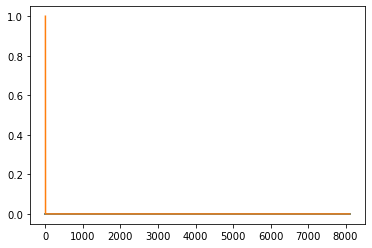

In [14]:
plt.plot(np.sort(G[0][:]))

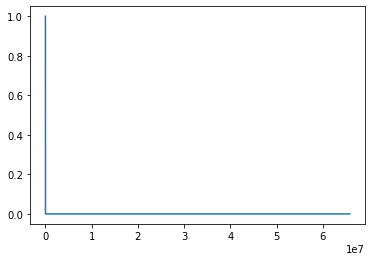

In [18]:
plt.plot(G[0].flatten())

In [21]:
np.sum(G[0].flatten() >= 0.001)

1

In [22]:
SS = np.sort(G[0].flatten())

In [25]:
SS[-2]

2.8769932531276937e-06

In [27]:
S = submodularSensorSelection(dmd_res['A'], gramT=5, maxSensors=10, subCriteria=1)


ValueError: Inexact indices into sparse matrices are not allowed

In [11]:
import scipy as sp
from scipy import sparse
S = sparse.csr_matrix(np.zeros((4,4)))
S

<4x4 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>